---
title: "Post 6 - Investigating Overfitting,  Overparameterization, and Double-Descent"
author: Col McDermott
date: "04-12-2025"
description: "An introductory examination of overfitting, overparameterization, and double-descent instances with ML models."
format: html
code-fold: true
execute:
  warning: false
  message: false
---

# Abstract

Classically, the standard approach towards constructing a supervised ML model begins with harnessing a dataset with an arbitrary number of data points each containing a uniform arbitrary number of features.  The dataset is then split into at least two subsets: one for training the model and the other for testing the model.  The underlying goals of model construction and refinement are to tweak the parameters of the model to produce desirable results for the given problem of focus (such as general classification or regression) with respect to the training data.  Finally, the model attempts to generalize the patterns that it identified in the training data to the unseen testing data.  Generally, the more complex (i.e. parameterized) a model is designed to be allows it to achieve higher training-data accuracy.  To a point, the gains in training-data accuracy (or loss in training-data error) translate to test-data performance, but as a model is made too complex (i.e. overparameterized), it begins to regress in test-data performance.  In general, it is believed that after a certain threshold of training-data improvement, the testing data performance will either plateau or continually decrease.  Yet, this need not strictly be the case.  While overfitting leads to decreasing generalized behavior at first, it can later observed to produce testing results better than the peak performance prior to overfitting: A phenomenon called Double-Descent.

In this short study, using a rudimentary, from-scratch linear regression model, I aim to investigate the results of overparameterization and they relate to initial overfitting followed by the double-descent phenomenon.  To conduct my analysis of these topics, I will first explore the mathematical properties related to an overprameterized linear regression model.  I will then construct an overparamterized model and evaluate its performance on generated, non-linear preprocessed data after applying a feature map.  Finally, I will apply my overparamterized model to a more complex dataset of corrupted images and explore how the model performance (measured in ability to predict the number of corruptions in an image) changes with adding more features to the model, with the intention of uncovering an instance of double-descent.

As discussed further in the sections below, for the generated, nonlinear data, I found that a more complex model produced a more accurate regression line and lower MSE.  Upon evaluating the model performance on the corrupted image dataset, I found that the model's testing performance did indeed exhibit an instance of double-descent, and the model's peak testing data performance occurred at a point of model complexity well beyond the interpolation threshold.

For more information on my overparameterized linear regression model and random feature map implementation, check out [OPLinearRegression.py](https://github.com/Col-McDermott/Col-McDermott.github.io/blob/main/posts/post_6/OPLinearRegression.py) and [RandFeatures.py](https://github.com/Col-McDermott/Col-McDermott.github.io/blob/main/posts/post_6/RandFeatures.py)

In [282]:
# Including all additional imports
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_sample_images
from matplotlib import pyplot as plt
from scipy.ndimage import zoom
import torch as tch
import pandas as pd
import numpy as np
import sys

# Porting over linear regression and feature map implementation
%load_ext autoreload
%autoreload 2
from OPLinearRegression import LinearRegression, OPLinearRegressionOptimizer
from RandFeatures import RandomFeatures
tch.manual_seed(50) # For consistent data generation
plt.style.use('seaborn-v0_8-whitegrid') # For consistent plotting

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Implementing an Overparameterized Linear Regression Model

### Mathematics Behind Overparameterization

Prior to constructing an overparameterized model, it is important to analyze the mathematical properties that prevent or need to be changed in order to allow for overparameterization to exist.  When constructing a standard linear regression model, the weights vector $\mathbf{w}$ is optimized to minimize the standard, unregularized mean-squared-error loss function:

$$
L(\mathbf{w}) = \frac{1}{n}\sum_{i=1}^{n}(\langle\mathbf{w}, \phi(x_i)\rangle - y_i)^2
$$

Note that $\phi(\mathbf{X})$ represents the application of the feature map $\phi$ to the original feature matrix $\mathbf{X}$.  The optimal weights vector $\mathbf{w}$ can be solved using $\hat{\mathbf{w}} = \text{argmin}_{\mathbf{w}}\|\mathbf{X}\mathbf{w} - \mathbf{y}\|^2$.  This expression takes the closed form of:

$$
\hat{\mathbf{w}} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}
$$

Overparameterization occurs when the number of features in the model exceeds the number of data points.  That is, when elements in $\mathbf{w}$ exceed the number of rows in $\mathbf{X}$, a model is overparameterized.  Note that when this occurs, the above formula for the optimal $\mathbf{w}$ becomes mathematically impossible when the number of features $p$ is greater than the number of data points $n$ (given that $\mathbf{X}: n \times p$).  The reason for this is that when $\mathbf{X}: n \times p$ and $p > n$, the matrix $\mathbf{X}$ is strictly rank-deficient.  That is, the columns of $\mathbf{X}$ cannot be linearly-independent.  It follows from this that $\mathbf{X}^T\mathbf{X}$ is also rank-deficient because the rank of $\mathbf{X}^T\mathbf{X}$ is at most the rank of $\mathbf{X}$.  Thus, $\mathbf{X}^T\mathbf{X}$ is a singular matrix in this case and is therefore not invertible (i.e. $\mathbf{X}^T\mathbf{X})^{-1}$ is undefined).  This ultimately breaks down the above formula used to solve $\mathbf{w}$.

However, the optimal weights vector $\mathbf{w}$ can still be found even when a model is overparameterized.  The formula for finding the optimal $\mathbf{w}$ uses the Moore-Penrose pseudoinverse $\mathbf{X}^+$ of $\mathbf{X}$:

$$
\begin{align}
\hat{\mathbf{w}} &= \mathbf{X}^+\mathbf{y} \\
\hat{\mathbf{w}} &= \mathbf{X}^T(\mathbf{X}\mathbf{X}^T)^{-1}\mathbf{y}
\end{align}
$$

The above equation is used to find the optimal $\mathbf{w}$ for my implementation of an overparameterized linear regression model.

### Overparameterized Model

My implementation of an overparameterized linear model involves three class definitions: `LinearModel`, `LinearRegression`, and `OPLinearRegressionOptimizer`.

**`LinearModel`**:

-   `self.w`: An instance variable to store the weights vector $\mathbf{w}$ of a linear model.
-   `score(X)`: A method to compute the score $s_i$ for each data point in the feature matrix **$X$** using:

$$
s_i = \langle\mathbf{w}, x_i\rangle
$$

**`LinearRegression`** (inherits from **`LinearModel`**):

- `predict(X)`: A method that returns the vector of model predictions $\mathbf{y}$.  The model predictions are simply the scores $\mathbf{s}$ from the linear model.
-   `loss(X, y)`: A method to compute the mean-squared-error (MSE) between the model scores $\mathbf{s}$ and the targets $\mathbf{y}$.  The MSE is computed with (note that $\phi(\mathbf{X})$ represents the application of the feature map $\phi$ to the original feature matrix $\mathbf{X}$):

$$
L(\mathbf{w}) = \mathbf{MSE} = \frac{1}{n}\sum_{i=1}^{n}(\langle\mathbf{w}, \phi(x_i)\rangle - y_i)^2
$$ 

**`OPLinearRegressionOptimizer`**:

-   `self.lr`: An instance variable of a `LinearRegression` object.
-   `fit(X, y)`: A method that computes the optimal weights vector $\mathbf{w}$ using the Moore-Penrose pseudoinverse of $\mathbf{X}$:

$$
\begin{align*}
\hat{\mathbf{w}} &= \mathbf{X}^+\mathbf{y} \\
\hat{\mathbf{w}} &= \mathbf{X}^T(\mathbf{X}\mathbf{X}^T)^{-1}\mathbf{y}
\end{align*}
$$

### Random Feature Map

In order to create overparameterized versions of my linear regression model, I will be using a (slightly edited) random feature map implementation provided by Prof. Chodrow.  This feature map implementation involves a single class definition: `RandomFeatures`.  Upon constructing a `RandomFeatures` object, the number of features (`n_features`) present after data transformation transformation and the activation function can be manually adjusted.  Note that the default activation function is the logistic sigmoid function ($1$), but this parameter can also be set to the simple squaring function ($2$):

$$
\begin{align}
\sigma(x) &= \frac{1}{1 + e^{-x}} \\
y &= x^2
\end{align}
$$

## Testing the Overparameterized Linear Regression Model on Simple Generated data

To evaluate the correctness and performance of my implementation, the overparameterized linear regressison model is fit to and tested on some basic, nonlinear generated data.

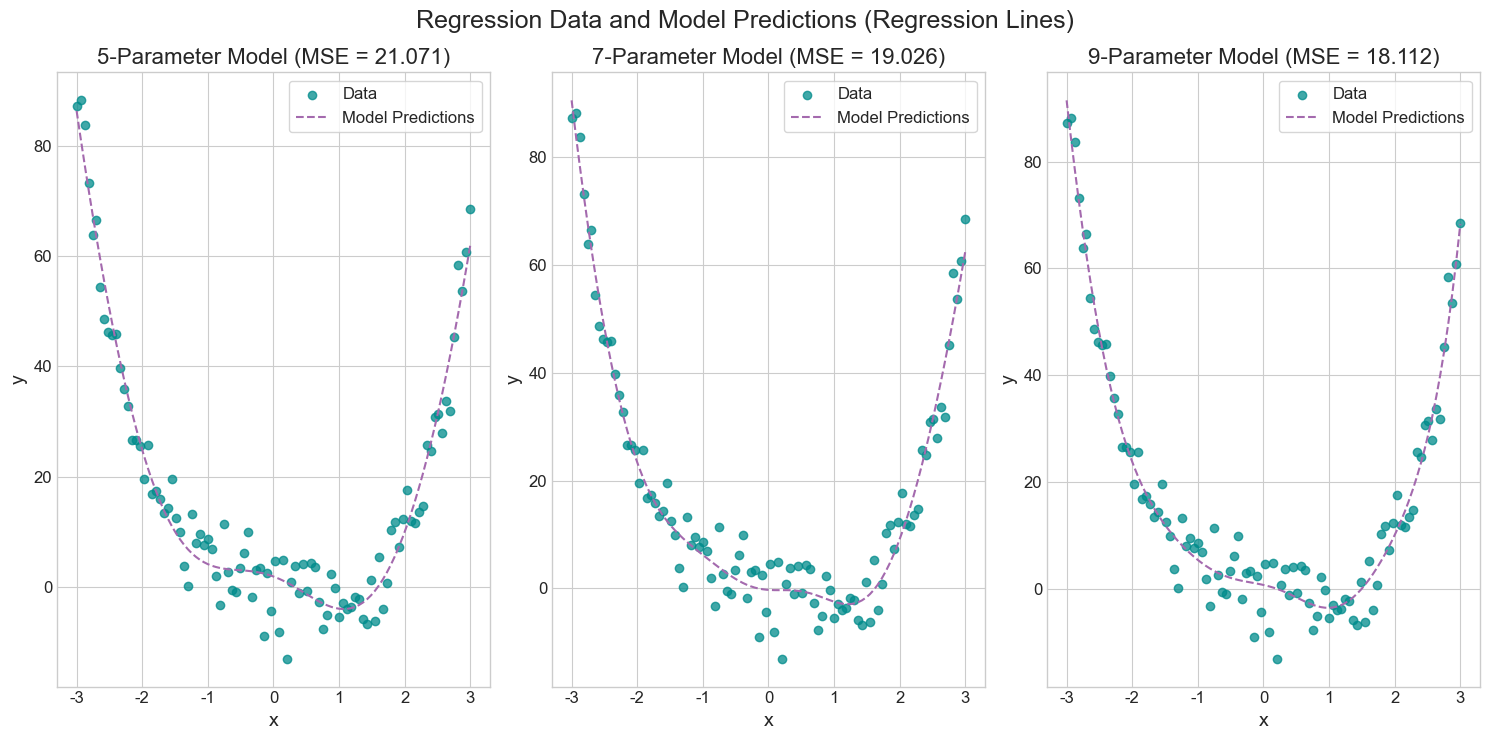

In [283]:
# Generating data - code provided by Prof. Chodrow
X = tch.tensor(np.linspace(-3, 3, 100).reshape(-1, 1), dtype = tch.float64)
y = (X ** 4) - (4 * X) + tch.normal(0, 5, size=X.shape)

# Initializing Linear Regression models
LinR1 = LinearRegression()
opt1 = OPLinearRegressionOptimizer(LinR1)
LinR2 = LinearRegression()
opt2 = OPLinearRegressionOptimizer(LinR2)
LinR3 = LinearRegression()
opt3 = OPLinearRegressionOptimizer(LinR3)

# Applying random feature maps
phi1 = RandomFeatures(5)
phi1.fit(X)
X_map1 = phi1.transform(X)
opt1.fit(X_map1, y)
y_hat1 = LinR1.predict(X_map1)
mse1 = LinR1.loss(X_map1, y)
phi2 = RandomFeatures(7)
phi2.fit(X)
X_map2 = phi2.transform(X)
opt2.fit(X_map2, y)
y_hat2 = LinR2.predict(X_map2)
mse2 = LinR2.loss(X_map2, y)
phi3 = RandomFeatures(9)
phi3.fit(X)
X_map3 = phi3.transform(X)
opt3.fit(X_map3, y)
y_hat3 = LinR3.predict(X_map3)
mse3 = LinR3.loss(X_map3, y)

# Plotting the data and regression lines
fig, ax = plt.subplots(1, 3, figsize = (15, 7.5))
ax[0].scatter(X, y, color = "darkcyan", label = "Data", alpha = 0.75)
ax[0].set_xlabel("x", fontsize = 14)
ax[0].set_ylabel("y", fontsize = 14)
ax[0].set_yticks([-20, 0, 20, 40, 60, 80, 100])
ax[0].set_yticklabels([str(i) for i in [-20, 0, 20, 40, 60, 80, 100]], fontsize = 12)
ax[0].set_xticks([-3, -2, -1, 0, 1, 2, 3])
ax[0].set_xticklabels([str(i) for i in [-3, -2, -1, 0, 1, 2, 3]], fontsize = 12)
ax[0].plot(X, y_hat1, color = "#A46AAE", linestyle = "--")
ax[0].legend(["Data", "Model Predictions"], fontsize = 12, frameon = True)
ax[0].set_title(f"5-Parameter Model (MSE = {round(mse1, 3)})", fontsize = 16)
ax[1].scatter(X, y, color = "darkcyan", label = "Data", alpha = 0.75)
ax[1].set_xlabel("x", fontsize = 14)
ax[1].set_ylabel("y", fontsize = 14)
ax[1].set_yticks([-20, 0, 20, 40, 60, 80, 100])
ax[1].set_yticklabels([str(i) for i in [-20, 0, 20, 40, 60, 80, 100]], fontsize = 12)
ax[1].set_xticks([-3, -2, -1, 0, 1, 2, 3])
ax[1].set_xticklabels([str(i) for i in [-3, -2, -1, 0, 1, 2, 3]], fontsize = 12)
ax[1].plot(X, y_hat2, color = "#A46AAE", linestyle = "--")
ax[1].legend(["Data", "Model Predictions"], frameon = True, fontsize = 12)
ax[1].set_title(f"7-Parameter Model (MSE = {round(mse2, 3)})", fontsize = 16)
ax[2].scatter(X, y, color = "darkcyan", label = "Data", alpha = 0.75)
ax[2].set_xlabel("x", fontsize = 14)
ax[2].set_ylabel("y", fontsize = 14)
ax[2].set_yticks([-20, 0, 20, 40, 60, 80, 100])
ax[2].set_yticklabels([str(i) for i in [-20, 0, 20, 40, 60, 80, 100]], fontsize = 12)
ax[2].set_xticks([-3, -2, -1, 0, 1, 2, 3])
ax[2].set_xticklabels([str(i) for i in [-3, -2, -1, 0, 1, 2, 3]], fontsize = 12)
ax[2].plot(X, y_hat3, color = "#A46AAE", linestyle = "--")
ax[2].legend(["Data", "Model Predictions"], frameon = True, fontsize = 12)
ax[2].set_title(f"9-Parameter Model (MSE = {round(mse3, 3)})", fontsize = 16)
fig.suptitle("Regression Data and Model Predictions (Regression Lines)", fontsize = 18)
plt.tight_layout()

*Code above generates some 1D regression data, fits a 5-, 7-, and 9-parameter, `LinearRegression` model to the generated data, and plots the data along with the model predictions (some code provided by Prof. Chodrow).*

**Figure 1**

Above shows the plots of some generated 1D, nonlinear data along with the corresponding regression line for a $5$-, $7$-, and $9$-parameter linear regression model (initialized using feature-map transformed data with the logistic sigmoid activation function).  Prior to plotting the model regression lines, the data is transformed with a random feature map of $5$, $7$, and $9$ features.  As expected, as the number of parameters per model increases, the corresponding regression line appears to follow the trend of the data more accurately.  In support of this, the MSE strictly decreases as the number of model parameters increases in this simple example: the lowest MSE corresponds to the highest-parameter model.  This aligns with the visual representation of the $9$-parameter model yielding the most accurate regression line.

## Testing the Overparameterized Linear Regression Model on a More Complex Dataset - Observing Double-Descent

### Retrieving and Processing Image Data 

To further evaluate the performance and properties of my implementation, the overperameterized linear regression model is fit and tested on a much more complex data set.  In this case, the data is a greyscale pixelated image of a flower (from the `sklearn.datasets` library).  The data, or image rather, will be "corrupted" (where contiguous groups of pixels are greyed out) to varying degrees, and the task of the model with given this data will be to predict the number of "corruptions" found in the given version of the image using just the image alone.  Specifically, a random dataset of $300$ corrupted images (including the corresponding number of corrections for each image) is created to fit and test the overparameterized regression model.  Below are references to the original, uncorrupted image used in this experiment and an example of a corrupted version of the image:

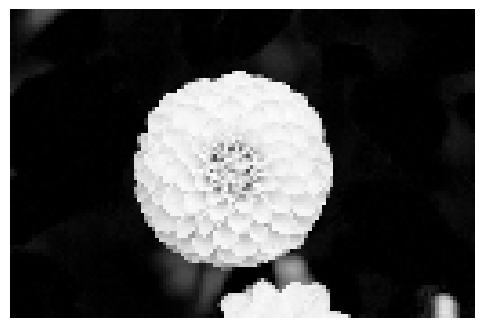

In [284]:
# Retrieving the image data for this experiment - code provided by Prof. Chodrow
dataset = load_sample_images()     
X = dataset.images[1]
X = zoom(X,.2) # Decimate resolution
X = X.sum(axis = 2)
X = X.max() - X 
X = X / X.max()
flower = tch.tensor(X, dtype = tch.float64)

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
ax.imshow(flower)
off = ax.axis("off")

*Code above retrieves and displays the image data for this experiment (code provided by Prof. Chodrow).*

**Image 1**

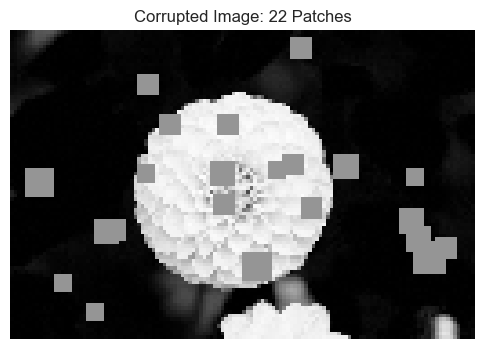

In [285]:
# Code used to corrupt the image data with random groups of greyed-out pixels - code provided by prof. Chodrow
def corrupted_image(im, mean_patches = 5): 
    n_pixels = im.size()
    num_pixels_to_corrupt = tch.round(mean_patches * tch.rand(1))
    num_added = 0
    X = im.clone()

    for _ in tch.arange(num_pixels_to_corrupt.item()): 
        try: 
            x = tch.randint(0, n_pixels[0], (2,))
            x = tch.randint(0, n_pixels[0], (1,))
            y = tch.randint(0, n_pixels[1], (1,))
            s = tch.randint(5, 10, (1,))
            patch = tch.zeros((s.item(), s.item()), dtype = tch.float64) + 0.5

            # Place patch in base image X
            X[x: x + s.item(), y: y + s.item()] = patch
            num_added += 1
        except: 
            pass

    return X, num_added

# Providing an example of a corrupted version of the image - code provided by Prof. Chodrow
X, y = corrupted_image(flower, mean_patches = 50)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(X.numpy(), vmin = 0, vmax = 1)
ax.set(title = f"Corrupted Image: {y} Patches")
off = plt.gca().axis("off")

# Generating a data set of random corrupted versions of the image - code provided by Prof. Chodrow
n_samples = 300
X = tch.zeros((n_samples, flower.size()[0], flower.size()[1]), dtype = tch.float64)
y = tch.zeros(n_samples, dtype = tch.float64)
for i in range(n_samples): 
    X[i], y[i] = corrupted_image(flower, mean_patches = 100)

# Reshaping the data for training
X = X.reshape(n_samples, -1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 50)

*Code above defines a function used to corrupt the image data by randomly creating patches of grey pixels and provides an example of corrupting an image using this function.  Code above also generates a data set of 300 random corrupted images and conducts a train-test-split ($50\%$ each) on the data set(code provided by Prof. Chodrow).*

**Image 2**

### Fitting A Model to the Corrupted Image Data

Now with a complex data set, the overparameterized linear regression model can be fit to and evaluated on its performance.  Further, the evolution of the MSE for both the training and testing data can be observed as the number of parameters in the model is increased.

In [286]:
# Assessing model performance across applying a few feature maps to the training data
num_feats = [0, 75, 150, 225]

# Evaluating model performance at the 4 different feature map sizes
for num_feat in num_feats:
    phi = RandomFeatures(num_feat, activation = 1)
    phi.fit(X_train)
    X_map_tr = phi.transform(X_train)
    X_map_tst = phi.transform(X_test)
    LinR = LinearRegression()
    opt = OPLinearRegressionOptimizer(LinR)
    opt.fit(X_map_tr, y_train)
    mse_tr = LinR.loss(X_map_tr, y_train)
    mse_tst = LinR.loss(X_map_tst, y_test)
    if num_feat == 150:
        print("----------")
        print(f"Mean Squared Error (Training, {num_feat}-Feature Map Applied | Interpolation Threshold): {round(mse_tr, 3) :.3f}")
        print(f"Mean Squared Error (Testing, {num_feat}-Feature Map Applied | Interpolation Threshold): {round(mse_tst, 3) :.3f}")
    else:    
        print("----------")
        print(f"Mean Squared Error (Training, {num_feat}-Feature Map Applied): {round(mse_tr, 3) :.3f}")
        print(f"Mean Squared Error (Testing, {num_feat}-Feature Map Applied): {round(mse_tst, 3) :.3f}")

----------
Mean Squared Error (Training, 0-Feature Map Applied): 2474.420
Mean Squared Error (Testing, 0-Feature Map Applied): 2633.267
----------
Mean Squared Error (Training, 75-Feature Map Applied): 65.882
Mean Squared Error (Testing, 75-Feature Map Applied): 455.639
----------
Mean Squared Error (Training, 150-Feature Map Applied | Interpolation Threshold): 0.000
Mean Squared Error (Testing, 150-Feature Map Applied | Interpolation Threshold): 27062.819
----------
Mean Squared Error (Training, 225-Feature Map Applied): 0.000
Mean Squared Error (Testing, 225-Feature Map Applied): 437.820


*Code above fits a `LinearRegression` model to the corrupted image data with several example feature maps applied (using the squaring activation function) and computes the MSE for both the training and testing data.*

The output above displays the MSE for both the training and testing data when the model is fit to the corrupted image data with a 0-feature, 75-feature, 150-feature (this is the interpolation threshold), and 225-feature feature map applied.  As expected, the MSE for the training data is lower than that of the testing data for each model, and the training data MSE strictly decreases.  As expected the training data MSE becomes $0.0$ once the model meets and exceeds the interpolation threshold.  The testing data MSE is shown to decrease as the training data MSE decreases and before the model complexity meets the interpolation threshold.  At the interpolation threshold, the testing data MSE significantly increases, strongly suggesting that the model notably overfits to the training data.  However, when the model complexity exceeds the interpolation threshold, the testing data MSE appears to drop back down again.  This is indicative of an instance of double-descent, suggesting that the minimal testing data MSE might be produced by an overparameterized model.  The figure below investigates this double-descent phenomenon further.

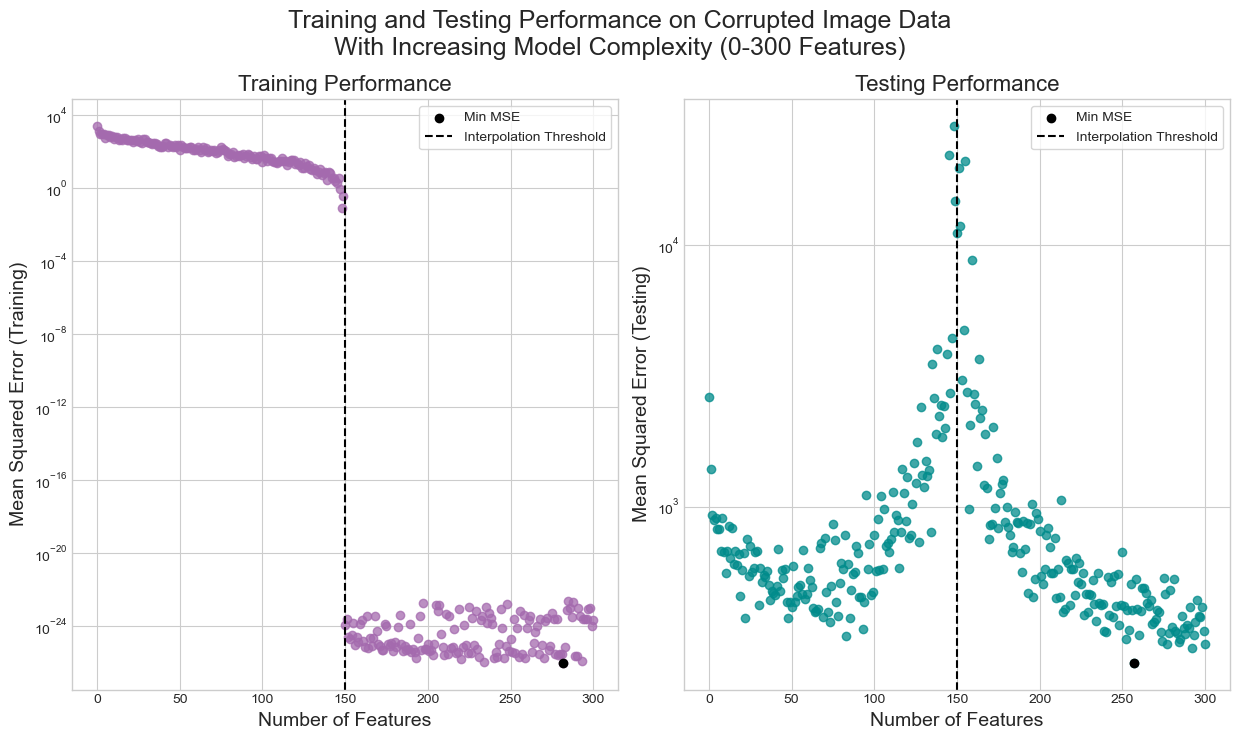

In [287]:
# Fitting many models with increasing feature sizes and assessing the training/testing performance
## Book keeping arrays for future plotting
mses_tr = []
mses_tst = []
num_feats = []
int_thrsh = X_train.size()[0]
min_mse_tr = sys.float_info.max
bst_tr_feats = 0
min_mse_tst = sys.float_info.max
bst_tst_feats = 0

# Fitting models with increasing feature sizes
for i in range(301):
    
    # Applying the increasingly complex feature maps - using the squaring activation function
    phi = RandomFeatures(i, activation = 1)
    phi.fit(X_train)
    X_map_tr = phi.transform(X_train)
    X_map_tst = phi.transform(X_test)

    # Initializing/fitting a model
    LinR = LinearRegression()
    opt = OPLinearRegressionOptimizer(LinR)
    opt.fit(X_map_tr, y_train)
    
    # Computing the training/testing performance and updating the best training/testing MSE
    mse_tr = LinR.loss(X_map_tr, y_train)
    mse_tst = LinR.loss(X_map_tst, y_test)
    if mse_tr < min_mse_tr:
        min_mse_tr = mse_tr
        bst_tr_feats = i
    if mse_tst < min_mse_tst:
        min_mse_tst = mse_tst
        bst_tst_feats = i
    
    # Recording current performance
    mses_tr.append(mse_tr)
    mses_tst.append(mse_tst)
    num_feats.append(i)

# Plotting the training/testing performance of each model
fig, ax = plt.subplots(1, 2, figsize = (12.5, 7.5))

# Training performance
ax[0].scatter(num_feats, mses_tr, color = "#A46AAE", alpha = 0.75)
ax[0].scatter(num_feats[bst_tr_feats], min_mse_tr, color = "black", label = "Min MSE")
ax[0].set_yscale("log")
ax[0].axvline(x = int_thrsh, color = "black", linestyle = "--", label = "Interpolation Threshold")
ax[0].set_xlabel("Number of Features", fontsize = 14)
ax[0].set_ylabel("Mean Squared Error (Training)", fontsize = 14)
ax[0].set_title("Training Performance", fontsize = 16)
ax[0].legend(frameon = True)

# Testing performance
ax[1].scatter(num_feats, mses_tst, color = "darkcyan", alpha = 0.75)
ax[1].scatter(num_feats[bst_tst_feats], min_mse_tst, color = "black", label = "Min MSE")
ax[1].set_yscale("log")
ax[1].axvline(x = int_thrsh, color = "black", linestyle = "--", label = "Interpolation Threshold")
ax[1].set_xlabel("Number of Features", fontsize = 14)
ax[1].set_ylabel("Mean Squared Error (Testing)", fontsize = 14)
ax[1].set_title("Testing Performance", fontsize = 16)
ax[1].legend(frameon = True)

fig.suptitle("Training and Testing Performance on Corrupted Image Data\nWith Increasing Model Complexity (0-300 Features)", fontsize = 18)
plt.tight_layout()

*Code above evaluates and stores the performance of the overparameterized linear regression model on the training and testing corrupted image data as the number of model features is increased from $[0, 300]$.  Code then plots the respective training and testing performances for each model, displaying the interpolation threshold and identifying the model/feature number corresponding to the minimum training and testing MSE (some code suggested by Prof. Chodrow).*

**Figure 2**

The plots above illustrate the evolution of the MSE for both the training and testing data as the overparameterized linear regression model complexity (i.e. number of features) increases.  Prior to exceeding the interpolation threshold, the training data MSE appears to steadily drop, which is expected as the model is gradually becoming more complex.  At the same time, the testing data MSE begins to drop, but soon starts to increase as the model complexity approaches the interpolation threshold.  This is also expected as the model is beginning to overfit to the training data more.  Once the number of features in the model exceeds the interpolation threshold, the model begins to notably overfit to the training data, ultimately bringing the training data MSE down to essentially $0.0$.  Aligning with this, the testing data MSE seems to be maximized when the model complexity is very close or equal to the interpolation threshold, indicating where the negative effects of training-data overfitting are most pronounced.  However, as the model complexity continues past the interpolation threshold, the testing data MSE begins to decrease again.  This is an instance of the double-descent phenomenon.

In [288]:
# Displaying the peak testing performance and corresponding number of features
print(f"Minimum MSE for Testing Data: {round(min_mse_tst, 3)} | Number of Features: {bst_tst_feats} (Interpolation Threshold: {int_thrsh})")
print(f"Minimum MSE for Training Data: {round(min_mse_tr, 3)} | Number of Features: {bst_tr_feats} (Interpolation Threshold: {int_thrsh})")

Minimum MSE for Testing Data: 252.059 | Number of Features: 257 (Interpolation Threshold: 150)
Minimum MSE for Training Data: 0.0 | Number of Features: 282 (Interpolation Threshold: 150)


*Code above displays the minimum MSE and the number of features in the corresponding model for both the training and testing corrupted image data.  The numbers of features in the corresponding models are compared to the interpolation threshold.*

The output above depicts the minimum (best) MSE values for the training and testing data along with the number of features in the corresponding models and a comparison to the interpolation threshold.  As expected, the minimum training data MSE is $0.0$ and occurs when the model has $282$ features; which is greater than the interpolation threshold at $150$.  The minimum testing data MSE occurs when the model has $257$ features; which is also greater than the interpolation threshold at $150$.  Interestingly, the best training and testing performances are produced by models with distinctly different complexities.  Yet overall, the information depicted above aligns with the double-descent occurrence shown in the previous plots.

# Discussion

The primary goals of this brief analysis were to investigate the concepts of overfitting, overparameterization, and the phenomenon of double-descent.  To explore these widely-recognized ML concepts, I implemented a basic linear regression model from scratch, that handles overparameterization using properties of the Moore-Penrose pseudoinverse of the feature matrix.  Additionally, to manually adjust the complexity of my linear regression model, I incorporated a random feature map implementation from Prof. Chodrow to transform training data and increase model complexity.  With this model and feature map framework, I conducted two primary experiments:

1. I fit the model to some generated, nonlinear data and observed the MSE performance of three different models with increasing complexity (number of features).
2. I fit the model to a more complex dataset of corrupted image data and observed the model's performance, through tracking the evolution of the MSE, as the model complexity was increased.  In particular, I assessed the MSE individually for the training and testing data from models containing $0$ up to $300$ features.  Note that this experiment included many models under-parameterized models, a model with a complexity equal to the interpolation threshold, and many overparameterized models.

In the first experiment, I used the three random feature maps (using the logistic sigmoid activation function) to transform the generated data and create three models each with a different complexity.  I found that the model's MSE got progressively lower as the models got progressively more complex.  Coupled with this, upon plotting the original data and each of the model's regression lines, I found that the more complex model produced regression lines that seemed to more closely follow the non-linear trend of the data.

In the second experiment, I began by retrieving a greyscale image of a flower from the `sklearn.datasets` library and corrupting it through creating patches of grey pixels randomly dispersed across the original image.  I then created a dataset of $300$ corrupted images and the corresponding number of corruptions for each image.  After transforming the corrupted image data with many random feature maps (this time using the squaring activation function), I then fit many versions of the overparametrized linear regression model to the image data.  Each model was tasked with predicting the number of corruptions found in a given image.  Specifically, I tracked the MSE of both the training and testing data produced by 300 different linear regression models, where each successive model became increasingly more complex (i.e., the numbers of features in the models increased in the range of $[0, 300]$).  To observe the trends in MSE and model complexity, I plotted the evolution of the training and testing MSE for each model as the complexity increased.  For the training data, I found that the model's performance slowly improved as the complexity increased, but once the model's complexity matched or exceeded the interpolation threshold of the training data, the training data MSE essentially dropped and remained at $0.0$.  Overall, I was not surprised to find this as it is expected that the model's training performance would be nearly perfect when it overfits to the training data.  For the testing data, I found that the models' performance initially improved (MSE dropped) as the model complexity increased, then sharply decreased (MSE spiked) once the model complexity approached and matched the interpolation threshold, but once again continued to improve and actually display peak performance (MSE dropped again and minimized) as the models' complexity grew beyond the interpolation threshold.  Overall, I found a clear example of the double-descent phenomenon to arise given my overparameterized linear regression model and the complex, corrupted image data.

In completing this study, I learned several key characteristics about crucial topics related to ML model design and overfitting.  In implementing my own overparametized linear regression model, I had the hands-on opportunity to explore the mathematical properties behind overparamterization and practice translating these properties into code.  I was also able to develop a more concrete understanding of randomized feature maps and how they can be used to transform training data to create more complex models.  Lastly, this study allowed me to explore and directly observe the causes of and results from model overfitting.  Following my experiments, I have a more well-rounded conception of both the implications behind the classical approach and understanding of overfitting and the counter-intuitive nature of double-descent.  Overall, this study stands as a valuable example of how certain classical beliefs in ML can be, and possibly should be, challenged, especially as the topics addressed in this analysis are some of the fundamental drivers of the most powerful modern ML models found today.